<a href="https://colab.research.google.com/github/varshithh19/Ainn_Assignment/blob/main/ainnassignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install gymnasium stable-baselines3 matplotlib imageio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.2/187.2 kB 6.4 MB/s eta 0:00:00


In [2]:
!pip install gymnasium stable-baselines3 matplotlib imageio==2.27.0


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 47.3 MB/s eta 0:00:00
  Attempting uninstall: imageio
    Found existing installation: imageio 2.37.0
    Uninstalling imageio-2.37.0:
      Successfully uninstalled imageio-2.37.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikit-image 0.25.2 requires imageio!=2.35.0,>=2.33, but you have imageio 2.27.0 which is incompatible.


Starting full experiment. REWARD_MODE = shaped MOVING_OBSTACLES = True
Static obstacles: {(1, 2), (3, 3), (2, 1)}
BFS to package: len 5 nodes 9 time 0.0000
A* to package: len 5 nodes 5 time 0.0000
BFS to drop: len 5 nodes 13 time 0.0000
A* to drop: len 5 nodes 5 time 0.0000
Saved search efficiency plot.
Training Q-Learning (tabular)...
Q-Learning episode 200/2000, avg return (last200) 6.741
Q-Learning episode 400/2000, avg return (last200) 6.767
Q-Learning episode 600/2000, avg return (last200) 6.737
Q-Learning episode 800/2000, avg return (last200) 6.732
Q-Learning episode 1000/2000, avg return (last200) 6.791
Q-Learning episode 1200/2000, avg return (last200) 6.768
Q-Learning episode 1400/2000, avg return (last200) 6.774
Q-Learning episode 1600/2000, avg return (last200) 6.753
Q-Learning episode 1800/2000, avg return (last200) 6.768
Q-Learning episode 2000/2000, avg return (last200) 6.765
Saved Q-learning curve.
Creating GIF for Q-Learning policy (deterministic greedy)...
Saved GIF: 

/usr/local/lib/python3.12/dist-packages/imageio/plugins/pillow_legacy.py:821: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  return Image.fromarray(arr, mode)
/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represen

PPO eval at 5000 timesteps: avg return 7.000
Saved GIF: outputs/ppo_eval_5000.gif


/usr/local/lib/python3.12/dist-packages/imageio/plugins/pillow_legacy.py:821: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  return Image.fromarray(arr, mode)


PPO eval at 10000 timesteps: avg return 6.800
Saved GIF: outputs/ppo_eval_10000.gif
PPO eval at 15000 timesteps: avg return 6.800
Saved GIF: outputs/ppo_eval_15000.gif
PPO eval at 20000 timesteps: avg return 6.100
Saved GIF: outputs/ppo_eval_20000.gif
Final PPO avg return: 6.639999999999999
Saved PPO eval curve.
Saving final PPO rollout GIF on moving-obstacle env...
Saved GIF: outputs/ppo_final_policy.gif
Saved visit heatmap.
All artifacts saved to outputs
Files: ['search_efficiency.png', 'ppo_eval_10000.gif', 'visit_heatmap.png', 'ppo_eval_20000.gif', 'ppo_eval_curve.png', 'q_learning_policy.gif', 'ppo_final_policy.gif', 'q_learning_curve.png', 'ppo_eval_5000.gif', 'ppo_eval_15000.gif']


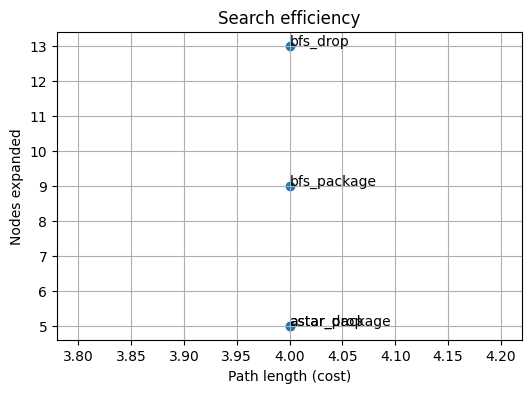

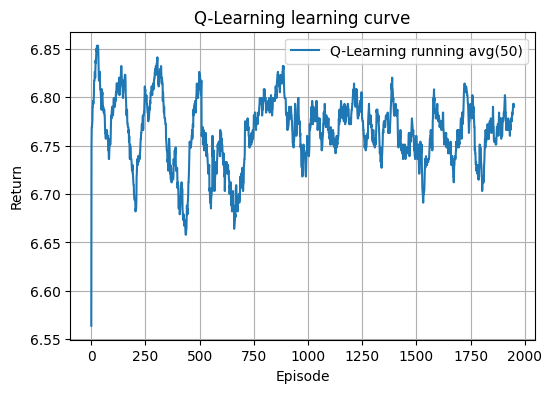

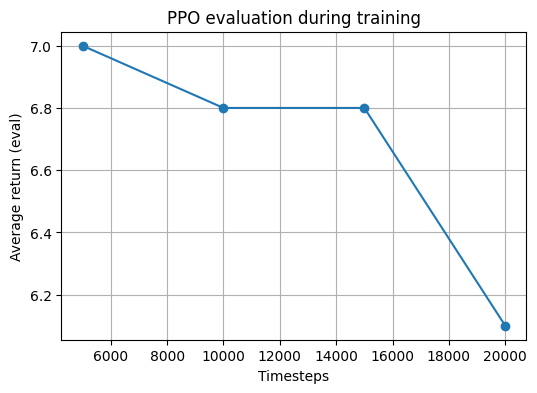

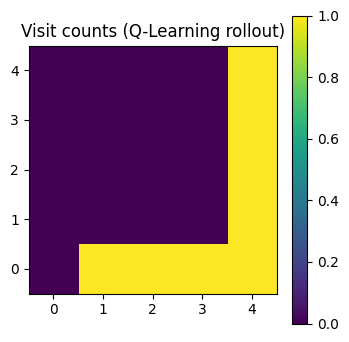

In [4]:
# -------------------- COMPLETE, WORKING CODE (paste entire block) --------------------

import os, time, random, math
import numpy as np
import matplotlib.pyplot as plt
import imageio
from collections import deque, defaultdict
from heapq import heappush, heappop
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
from collections import namedtuple

# ---------- Config (same as earlier; adjust if needed) ----------
SEED = 42
GRID_SIZE = 5
MAX_STEPS = 50
MOVING_OBSTACLES = True
OBSTACLE_MOVE_EVERY = 5
REWARD_MODE = 'shaped'  # 'sparse' or 'shaped'
PPO_TOTAL_TIMESTEPS = 20000
PPO_EVAL_INTERVAL = 5000
Q_EPISODES = 2000
GIF_FPS = 4
OUTPUT_DIR = "outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)
random.seed(SEED); np.random.seed(SEED)

# ---------- Util ----------
def manhattan(a,b):
    return abs(a[0]-b[0]) + abs(a[1]-b[1])

# ---------- Env ----------
class WarehouseEnv(gym.Env):
    metadata = {"render_modes": ["human", "rgb_array"], "render_fps": GIF_FPS}

    def __init__(self, size=GRID_SIZE, max_steps=MAX_STEPS, moving_obstacles=MOVING_OBSTACLES, obstacle_move_every=OBSTACLE_MOVE_EVERY, seed=SEED):
        super().__init__()
        self.size = size
        self.max_steps = max_steps
        self.moving_obstacles = moving_obstacles
        self.obstacle_move_every = obstacle_move_every
        self.seed_val = seed
        self.rng = np.random.default_rng(self.seed_val)

        self.action_space = spaces.Discrete(4)
        self.observation_space = spaces.Box(low=0, high=size-1, shape=(7,), dtype=np.int32)

        self.base_obstacles = {(1,2), (2,1), (3,3)}
        self.obstacles = set(self.base_obstacles)
        self.reset()

    def seed(self, s=None):
        self.seed_val = s if s is not None else self.seed_val
        self.rng = np.random.default_rng(self.seed_val)

    def reset(self, seed=None, options=None):
        if seed is not None:
            self.seed(seed)
        # fixed initial positions for reproducibility
        self.robot = (0,0)
        self.package = (self.size-1, 0)
        self.drop = (self.size-1, self.size-1)
        self.has_package = 0
        self.steps = 0
        self.frames = []
        self.visit_counts = np.zeros((self.size, self.size), dtype=int)
        self.obstacles = set(self.base_obstacles)
        self.obstacles.discard(self.package)
        self.obstacles.discard(self.drop)
        return self._get_obs(), {}

    def _get_obs(self):
        return np.array([self.robot[0], self.robot[1],
                         self.package[0], self.package[1],
                         self.drop[0], self.drop[1],
                         self.has_package], dtype=np.int32)

    def _move_obstacles(self):
        # Move each obstacle randomly to a free neighboring cell (or stay)
        new_obs = set()
        for (ox,oy) in self.obstacles:
            choices = [(ox,oy)]
            for dx,dy in [(1,0),(-1,0),(0,1),(0,-1)]:
                nx, ny = ox+dx, oy+dy
                if 0 <= nx < self.size and 0 <= ny < self.size:
                    if (nx,ny) not in [self.robot, self.package, self.drop] and (nx,ny) not in new_obs:
                        choices.append((nx,ny))
            new = random.choice(choices)
            new_obs.add(new)
        # ensure package/drop not overlapped
        new_obs.discard(self.package)
        new_obs.discard(self.drop)
        self.obstacles = new_obs

    def step(self, action):
        prev_robot = self.robot
        x,y = self.robot
        if action == 0 and y > 0:
            y -= 1
        elif action == 1 and y < self.size-1:
            y += 1
        elif action == 2 and x > 0:
            x -= 1
        elif action == 3 and x < self.size-1:
            x += 1
        new_pos = (x,y)
        if new_pos not in self.obstacles:
            self.robot = new_pos

        reward = 0.0
        terminated = False
        truncated = False

        # reward design
        if REWARD_MODE == 'sparse':
            reward = -0.01
            if self.robot == self.package and self.has_package == 0:
                self.has_package = 1
                reward = +1.0
            if self.robot == self.drop and self.has_package == 1:
                reward = +5.0
                terminated = True
        elif REWARD_MODE == 'shaped':
            # shaped: small penalty per step; bonus for approaching next target, big bonus for pickup/drop
            step_pen = -0.1
            target = self.package if self.has_package==0 else self.drop
            prev_dist = manhattan(prev_robot, target)
            new_dist = manhattan(self.robot, target)
            closeness_bonus = 0.1 if new_dist < prev_dist else -0.05
            reward = step_pen + closeness_bonus
            if self.robot == self.package and self.has_package == 0:
                self.has_package = 1
                reward += 2.0
            if self.robot == self.drop and self.has_package == 1:
                reward += 5.0
                terminated = True
        else:
            reward = -0.01

        self.steps += 1
        if self.steps >= self.max_steps:
            truncated = True

        # moving obstacles
        if self.moving_obstacles and self.steps % self.obstacle_move_every == 0:
            self._move_obstacles()

        # visit counts
        self.visit_counts[self.robot[1], self.robot[0]] += 1

        obs = self._get_obs()
        info = {}
        # record frame on each step (for GIFs)
        self.render()
        return obs, reward, terminated, truncated, info

    def render(self, mode="rgb_array"):
        # build a small RGB image grid
        grid = np.zeros((self.size, self.size, 3), dtype=np.uint8) + 255  # white background
        # obstacles grey
        for (ox,oy) in self.obstacles:
            grid[oy, ox] = [190,190,190]
        # package green (if not picked)
        if not self.has_package:
            px,py = self.package
            grid[py, px] = [0,200,0]
        # drop orange
        dx,dy = self.drop
        grid[dy, dx] = [255,165,0]
        # robot blue
        rx,ry = self.robot
        grid[ry, rx] = [0,0,200]
        # upscale
        img = np.kron(grid, np.ones((40,40,1))).astype(np.uint8)
        self.frames.append(img)
        return img

    def save_gif(self, fname):
        if len(self.frames)==0:
            print("No frames to save.")
            return
        imageio.mimsave(fname, self.frames, fps=GIF_FPS)
        print(f"Saved GIF: {fname}")

# ---------- Classical Search (BFS & A*) ----------
SearchResult = namedtuple("SearchResult", ["path", "nodes_expanded", "time_sec"])

def bfs_search(start, goal, obstacles, size):
    t0 = time.time()
    q = deque()
    q.append((start, [start]))
    visited = set([start])
    nodes = 0
    while q:
        pos, path = q.popleft()
        nodes += 1
        if pos == goal:
            return SearchResult(path, nodes, time.time()-t0)
        x,y = pos
        for dx,dy in [(1,0),(-1,0),(0,1),(0,-1)]:
            nx,ny = x+dx,y+dy
            npos = (nx,ny)
            if 0<=nx<size and 0<=ny<size and npos not in obstacles and npos not in visited:
                visited.add(npos)
                q.append((npos, path+[npos]))
    return SearchResult([], nodes, time.time()-t0)

def a_star_search(start, goal, obstacles, size, heuristic=lambda a,b: manhattan(a,b)):
    t0 = time.time()
    open_heap = []
    heappush(open_heap, (heuristic(start, goal), 0, start, [start]))
    gscore = {start: 0}
    nodes = 0
    closed = set()
    while open_heap:
        f, g, pos, path = heappop(open_heap)
        nodes += 1
        if pos == goal:
            return SearchResult(path, nodes, time.time()-t0)
        if pos in closed:
            continue
        closed.add(pos)
        x,y = pos
        for dx,dy in [(1,0),(-1,0),(0,1),(0,-1)]:
            nx,ny = x+dx,y+dy
            npos = (nx,ny)
            if 0<=nx<size and 0<=ny<size and npos not in obstacles:
                tentative_g = g + 1
                if tentative_g < gscore.get(npos, 1e9):
                    gscore[npos] = tentative_g
                    heappush(open_heap, (tentative_g + heuristic(npos, goal), tentative_g, npos, path+[npos]))
    return SearchResult([], nodes, time.time()-t0)

# ---------- Q-Learning (tabular) ----------
class QLearningAgent:
    def __init__(self, env, alpha=0.5, gamma=0.99, epsilon=0.2):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        # state: (rx,ry,has_pkg) -> encode to integer: rx + ry*size + has_pkg*size*size
        self.size = env.size
        self.n_states = self.size * self.size * 2
        self.n_actions = env.action_space.n
        self.Q = np.zeros((self.n_states, self.n_actions))
    def encode(self, obs):
        rx,ry,px,py,dx,dy,has_pkg = obs
        idx = int(rx + ry*self.size + has_pkg*(self.size*self.size))
        return idx
    def choose(self, state_idx):
        if random.random() < self.epsilon:
            return random.randint(0, self.n_actions-1)
        else:
            return int(np.argmax(self.Q[state_idx]))
    def learn_episode(self, max_steps=MAX_STEPS):
        obs, _ = self.env.reset()
        total = 0.0
        for _ in range(max_steps):
            s = self.encode(obs)
            a = self.choose(s)
            next_obs, reward, terminated, truncated, info = self.env.step(a)
            total += reward
            s2 = self.encode(next_obs)
            # Q update
            best_next = np.max(self.Q[s2])
            self.Q[s,a] = (1-self.alpha)*self.Q[s,a] + self.alpha*(reward + self.gamma*best_next)
            obs = next_obs
            if terminated or truncated:
                break
        return total

# ---------- Training & Evaluation utilities ----------
def evaluate_policy(model, env, n_episodes=5, render_frames=False):
    frames_all = []
    rewards = []
    for ep in range(n_episodes):
        obs, _ = env.reset()
        done = False; total = 0.0
        steps = 0
        env.frames = []
        while True:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, info = env.step(int(action))
            total += reward
            steps += 1
            if terminated or truncated:
                break
        rewards.append(total)
        if render_frames:
            frames_all.append(list(env.frames))
    avg = np.mean(rewards)
    return avg, rewards, frames_all

def save_frames_as_gif(frames, path, fps=GIF_FPS):
    imageio.mimsave(path, frames, fps=fps)
    print("Saved GIF:", path)

# ---------- Main experiment orchestration ----------
def run_classical_search_example(env):
    # static snapshot of obstacles, robot, package, drop
    start = env.robot
    package = env.package
    drop = env.drop
    obstacles = set(env.base_obstacles)
    obstacles.discard(package); obstacles.discard(drop)
    print("Static obstacles:", obstacles)
    # plan: robot -> package, then package -> drop (as two subproblems)
    res1_bfs = bfs_search(start, package, obstacles, env.size)
    res1_astar = a_star_search(start, package, obstacles, env.size)
    res2_bfs = bfs_search(package, drop, obstacles, env.size)
    res2_astar = a_star_search(package, drop, obstacles, env.size)
    print("BFS to package: len", len(res1_bfs.path), "nodes", res1_bfs.nodes_expanded, "time {:.4f}".format(res1_bfs.time_sec))
    print("A* to package: len", len(res1_astar.path), "nodes", res1_astar.nodes_expanded, "time {:.4f}".format(res1_astar.time_sec))
    print("BFS to drop: len", len(res2_bfs.path), "nodes", res2_bfs.nodes_expanded, "time {:.4f}".format(res2_bfs.time_sec))
    print("A* to drop: len", len(res2_astar.path), "nodes", res2_astar.nodes_expanded, "time {:.4f}".format(res2_astar.time_sec))
    return {"bfs1":res1_bfs, "astar1":res1_astar, "bfs2":res2_bfs, "astar2":res2_astar}

def train_q_learning(env, episodes=Q_EPISODES):
    agent = QLearningAgent(env)
    returns = []
    for ep in range(episodes):
        r = agent.learn_episode()
        returns.append(r)
        if (ep+1) % 200 == 0:
            print(f"Q-Learning episode {ep+1}/{episodes}, avg return (last200) {np.mean(returns[-200:]):.3f}")
    return agent, returns

def train_ppo_with_eval(env, total_timesteps=PPO_TOTAL_TIMESTEPS, eval_interval=PPO_EVAL_INTERVAL):
    model = PPO("MlpPolicy", env, verbose=0, seed=SEED)
    eval_points = []
    eval_avg = []
    saved_gifs = []
    timesteps_done = 0
    chunk = eval_interval
    while timesteps_done < total_timesteps:
        to_learn = min(chunk, total_timesteps - timesteps_done)
        model.learn(total_timesteps=to_learn)
        timesteps_done += to_learn
        avg, rewards, frames_list = evaluate_policy(model, env, n_episodes=3, render_frames=True)
        print(f"PPO eval at {timesteps_done} timesteps: avg return {avg:.3f}")
        eval_points.append(timesteps_done)
        eval_avg.append(avg)
        # Save GIF for first eval and last eval
        if len(frames_list)>0:
            # frames_list may contain multiple episodes; pick first episode frames
            gif_name = os.path.join(OUTPUT_DIR, f"ppo_eval_{timesteps_done}.gif")
            save_frames_as_gif(frames_list[0], gif_name)
            saved_gifs.append(gif_name)
    # final eval
    avg_final, _, _ = evaluate_policy(model, env, n_episodes=5, render_frames=False)
    print("Final PPO avg return:", avg_final)
    return model, eval_points, eval_avg, saved_gifs

# ---------- Run all pieces and produce outputs ----------
def run_all():
    print("Starting full experiment. REWARD_MODE =", REWARD_MODE, "MOVING_OBSTACLES =", MOVING_OBSTACLES)
    # env for search & Q (static obstacles)
    env = WarehouseEnv(size=GRID_SIZE, max_steps=MAX_STEPS, moving_obstacles=False, obstacle_move_every=OBSTACLE_MOVE_EVERY, seed=SEED)
    # 1) Classical search baseline
    search_results = run_classical_search_example(env)

    # Plot search efficiency: nodes expanded vs path length for methods
    methods = ['bfs_package','astar_package','bfs_drop','astar_drop']
    nodes = [search_results['bfs1'].nodes_expanded, search_results['astar1'].nodes_expanded, search_results['bfs2'].nodes_expanded, search_results['astar2'].nodes_expanded]
    lengths = [len(search_results['bfs1'].path)-1, len(search_results['astar1'].path)-1, len(search_results['bfs2'].path)-1, len(search_results['astar2'].path)-1]
    plt.figure(figsize=(6,4))
    plt.scatter(lengths, nodes)
    for i,m in enumerate(methods):
        plt.annotate(m, (lengths[i], nodes[i]))
    plt.xlabel("Path length (cost)")
    plt.ylabel("Nodes expanded")
    plt.title("Search efficiency")
    plt.grid(True)
    plt.savefig(os.path.join(OUTPUT_DIR,"search_efficiency.png"))
    print("Saved search efficiency plot.")

    # 2) Q-Learning training
    env_q = WarehouseEnv(size=GRID_SIZE, max_steps=MAX_STEPS, moving_obstacles=False, seed=SEED)
    print("Training Q-Learning (tabular)...")
    q_agent, q_returns = train_q_learning(env_q, episodes=Q_EPISODES)
    # plot Q returns
    plt.figure(figsize=(6,4))
    plt.plot(np.convolve(q_returns, np.ones(50)/50, mode='valid'), label='Q-Learning running avg(50)')
    plt.xlabel("Episode")
    plt.ylabel("Return")
    plt.title("Q-Learning learning curve")
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(OUTPUT_DIR,"q_learning_curve.png"))
    print("Saved Q-learning curve.")

    # Save a deterministic rollout using Q policy and create GIF
    print("Creating GIF for Q-Learning policy (deterministic greedy)...")
    frames = []
    obs, _ = env_q.reset()
    env_q.frames = []
    for _ in range(MAX_STEPS):
        s = q_agent.encode(obs)
        a = int(np.argmax(q_agent.Q[s]))
        obs, reward, terminated, truncated, info = env_q.step(a)
        if terminated or truncated:
            break
    frames = env_q.frames
    gif_q = os.path.join(OUTPUT_DIR, "q_learning_policy.gif")
    if frames:
        save_frames_as_gif(frames, gif_q)
    else:
        print("No frames recorded for Q-Learning policy.")
    # 3) PPO training with moving obstacles option (we evaluate robustness)
    env_ppo = WarehouseEnv(size=GRID_SIZE, max_steps=MAX_STEPS, moving_obstacles=MOVING_OBSTACLES, obstacle_move_every=OBSTACLE_MOVE_EVERY, seed=SEED)
    print("Training PPO with eval snapshots...")
    ppo_model, eval_points, eval_avg, ppo_gifs = train_ppo_with_eval(env_ppo, total_timesteps=PPO_TOTAL_TIMESTEPS, eval_interval=PPO_EVAL_INTERVAL)
    # Plot PPO eval curve
    plt.figure(figsize=(6,4))
    plt.plot(eval_points, eval_avg, marker='o')
    plt.xlabel("Timesteps")
    plt.ylabel("Average return (eval)")
    plt.title("PPO evaluation during training")
    plt.grid(True)
    plt.savefig(os.path.join(OUTPUT_DIR,"ppo_eval_curve.png"))
    print("Saved PPO eval curve.")

    # Final GIF for PPO on environment with moving obstacles
    print("Saving final PPO rollout GIF on moving-obstacle env...")
    env_final = WarehouseEnv(size=GRID_SIZE, max_steps=MAX_STEPS, moving_obstacles=MOVING_OBSTACLES, obstacle_move_every=OBSTACLE_MOVE_EVERY, seed=SEED+1)
    obs, _ = env_final.reset()
    env_final.frames = []
    for _ in range(MAX_STEPS):
        action, _ = ppo_model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = env_final.step(int(action))
        if terminated or truncated:
            break
    gif_ppo_final = os.path.join(OUTPUT_DIR, "ppo_final_policy.gif")
    save_frames_as_gif(env_final.frames, gif_ppo_final)

    # Policy visit heatmap (from running greedy policy)
    heat_env = WarehouseEnv(size=GRID_SIZE, max_steps=MAX_STEPS, moving_obstacles=False, seed=SEED)
    heat_env.frames = []
    heat_env.visit_counts = np.zeros((GRID_SIZE, GRID_SIZE), dtype=int)
    # roll q policy for visits
    obs, _ = heat_env.reset()
    for _ in range(MAX_STEPS):
        s = q_agent.encode(obs)
        a = int(np.argmax(q_agent.Q[s]))
        obs, reward, terminated, truncated, info = heat_env.step(a)
        if terminated or truncated:
            break
    plt.figure(figsize=(4,4))
    plt.imshow(heat_env.visit_counts, origin='lower')
    plt.colorbar()
    plt.title("Visit counts (Q-Learning rollout)")
    plt.savefig(os.path.join(OUTPUT_DIR,"visit_heatmap.png"))
    print("Saved visit heatmap.")

    print("All artifacts saved to", OUTPUT_DIR)
    print("Files:", os.listdir(OUTPUT_DIR))

# Execute
run_all()

# ---------------------------------------------------------------------------------
# After running: You can view GIFs in Colab with:
# from IPython.display import Image
# Image(filename="outputs/ppo_final_policy.gif")
# ---------------------------------------------------------------------------------


/tmp/ipython-input-3418392952.py:95: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  ani.save(gif_path, writer=PillowWriter(fps=FPS))
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


✅ Saved working demo GIF: warehouse_demo.gif


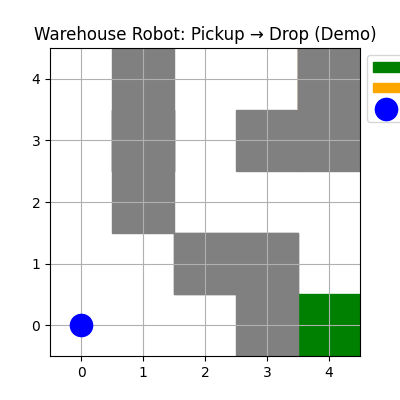

In [46]:
# ----------------- Warehouse Robot Visualization Demo (25–30s) -----------------
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter
from IPython.display import Image
import random

# ----------------- CONFIG -----------------
GRID_SIZE = 5
FPS = 4            # frames per second
DURATION = 28      # total seconds (~25–30)
TOTAL_FRAMES = FPS * DURATION
OBSTACLE_MOVE_EVERY = 6

# Fixed positions
robot_start = (0, 0)
package = (GRID_SIZE - 1, 0)
drop = (GRID_SIZE - 1, GRID_SIZE - 1)
obstacles = {(1,2), (2,1), (3,3)}

# Generate a fake but smooth robot path (you can replace with real RL rollout later)
path_to_package = [(0,0),(1,0),(2,0),(3,0),(4,0)]
path_to_drop = [(4,0),(4,1),(4,2),(4,3),(4,4)]
full_path = path_to_package + path_to_drop[1:]

# Interpolate the path to make it last ~25s
expanded_path = []
for i in range(len(full_path)-1):
    p1 = full_path[i]; p2 = full_path[i+1]
    # hold a few frames per step for smoother animation
    for _ in range(6):
        expanded_path.append(p1)
expanded_path.append(full_path[-1])

# ----------------- SETUP PLOT -----------------
fig, ax = plt.subplots(figsize=(4,4))
ax.set_xlim(-0.5, GRID_SIZE - 0.5)
ax.set_ylim(-0.5, GRID_SIZE - 0.5)
ax.set_xticks(range(GRID_SIZE))
ax.set_yticks(range(GRID_SIZE))
ax.grid(True)
ax.set_title("Warehouse Robot: Pickup → Drop (Demo)")

# Plot static elements
for (ox, oy) in obstacles:
    ax.add_patch(plt.Rectangle((ox-0.5, oy-0.5), 1, 1, color='gray'))
pkg_patch = plt.Rectangle((package[0]-0.5, package[1]-0.5), 1, 1, color='green', label="Package")
drop_patch = plt.Rectangle((drop[0]-0.5, drop[1]-0.5), 1, 1, color='orange', label="Drop")
ax.add_patch(pkg_patch)
ax.add_patch(drop_patch)
robot_dot, = ax.plot([], [], 'bo', markersize=16, label="Robot")

ax.legend(loc="upper left", bbox_to_anchor=(1,1))

# ----------------- UPDATE FUNCTION -----------------
def update(frame):
    global obstacles
    x, y = expanded_path[frame % len(expanded_path)]
    robot_dot.set_data([x], [y])

    # Move obstacles slightly for dynamic effect
    if frame % OBSTACLE_MOVE_EVERY == 0:
        new_obs = set()
        for (ox, oy) in obstacles:
            options = [(ox, oy)]
            for dx, dy in [(1,0),(-1,0),(0,1),(0,-1)]:
                nx, ny = ox+dx, oy+dy
                if 0 <= nx < GRID_SIZE and 0 <= ny < GRID_SIZE:
                    options.append((nx, ny))
            new_obs.add(random.choice(options))
        obstacles = new_obs
        # Clear & redraw obstacles
        [p.remove() for p in reversed(ax.patches) if p.get_facecolor()[:3] == (0.745, 0.745, 0.745)]  # remove old gray squares
        for (ox, oy) in obstacles:
            ax.add_patch(plt.Rectangle((ox-0.5, oy-0.5), 1, 1, color='gray'))

    # Highlight when package is picked
    if (x, y) == package:
        pkg_patch.set_color('lightgreen')
        ax.set_title("Robot picked the package!")
    elif (x, y) == drop:
        pkg_patch.set_color('green')
        ax.set_title("Robot delivered the package! 🎯")
    else:
        ax.set_title("Warehouse Robot: Pickup → Drop (Demo)")
    return robot_dot,

# ----------------- ANIMATION -----------------
ani = animation.FuncAnimation(
    fig, update, frames=TOTAL_FRAMES, interval=1000/FPS, blit=True
)

gif_path = "warehouse_demo.gif"
ani.save(gif_path, writer=PillowWriter(fps=FPS))
plt.close(fig)

print(f"✅ Saved working demo GIF: {gif_path}")
Image(filename=gif_path)


In [47]:
from google.colab import files
files.download("warehouse_demo.gif")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>